# Prepare run

## Import libraries and functions

In [1]:
import os
import re
import keras
import scipy
import pickle
import crested
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
from crested.tl.zoo import dilated_cnn
from crested.tl.data import AnnDataModule
from crested.tl import default_configs, TaskConfig

import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

Define custom functions

In [2]:
def calculate_mutagenesis(scores, length, shift):

    # Finds the most frequent value and sets it to NaN (ISM without change)
    most_common = scipy.stats.mode(scores, nan_policy='omit').mode[0]
    scores[scores == most_common] = np.nan

    arr_a = scores[shift:shift+length, 0]
    arr_c = scores[shift:shift+length, 1]
    arr_g = scores[shift:shift+length, 2]
    arr_t = scores[shift:shift+length, 3]

    arr_a[arr_a == 0] = None
    arr_c[arr_c == 0] = None
    arr_g[arr_g == 0] = None
    arr_t[arr_t == 0] = None

    return {"A":arr_a, "C":arr_c, "G":arr_g, "T":arr_t}


def get_mpra_values(path, length, shift=396143, pval=0.00001):
    seq = {}
    mpra = {}
    with open(path,'r') as f:
        first_line = f.readline()
        for line in f:
            splitted_line = line.strip().split('\t')
            if int(splitted_line[1]) not in seq:
                seq[int(splitted_line[1])] = splitted_line[2]
            if int(splitted_line[1]) not in mpra:
                mpra[int(splitted_line[1])] = {'A':[], 'C':[], 'G':[], 'T':[]}
            if splitted_line[3] != '-' and int(splitted_line[4]) >= 10:
                mpra[int(splitted_line[1])][splitted_line[3]] = [float(splitted_line[7]), float(splitted_line[8])]

    array_ = {'A':np.empty(length),'C':np.empty(length),'G':np.empty(length),'T':np.empty(length)}
    array_['A'][:] = np.nan
    array_['C'][:] = np.nan
    array_['T'][:] = np.nan
    array_['G'][:] = np.nan

    for i in range(length):
        if i + shift in mpra:
            for key in mpra[i+shift]:
                if mpra[i+shift][key] != []:
                    if mpra[i+shift][key][1] < pval:
                        array_[key][i] = mpra[i+shift][key][0]
    
    array_['A'][array_['A']==0] = None
    array_['C'][array_['C']==0] = None
    array_['G'][array_['G']==0] = None
    array_['T'][array_['T']==0] = None  

    seq = ''.join(seq.values())
    return array_, seq


def find_differences(str1, str2):
    differences = [(i, c1, c2) for i, (c1, c2) in enumerate(zip(str1, str2)) if c1 != c2]
    return differences


def plot_kircher_correlation(
    scores,
    genome_seq,
    path,
    length=600,
    shift_model=756,
    shift_mpra=109274652,
    pval_threshold=1e-5,
    save_path=None,
    correlation='spearman',
    rasterized=True
):
    model_ism = calculate_mutagenesis(scores[0][0], length=length, shift=shift_model)
    kircher, seq = get_mpra_values(path=path, length=length, shift=shift_mpra, pval=pval_threshold)
    
    diffs = find_differences(genome_seq[0], seq)
    if diffs:
        print(f'Differences found: {diffs}')
    
    model_mpra = []
    kircher_mpra = []
    
    for i in range(length):
        for base in ['A', 'C', 'G', 'T']:
            if not np.isnan(kircher[base][i]):
                kircher_mpra.append(kircher[base][i])
                model_mpra.append(model_ism[base][i])
    
    kircher_mpra = np.array(kircher_mpra)
    model_mpra = np.array(model_mpra)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(kircher_mpra, model_mpra, alpha=0.6, edgecolors='k', rasterized=rasterized)
    
    nas = np.logical_or(np.isnan(kircher_mpra), np.isnan(model_mpra))

    if correlation == 'spearman':
        corr, pval = scipy.stats.spearmanr(kircher_mpra[~nas], model_mpra[~nas])
        ax.set_title(f'Spearman correlation: {corr:.3f}, p-value: {pval:.3e}', fontsize=14)
    else:
        corr, pval = scipy.stats.pearsonr(kircher_mpra[~nas], model_mpra[~nas])
        ax.set_title(f'Pearson correlation: {corr:.3f}, p-value: {pval:.3e}', fontsize=14)

    ax.set_xlabel("In vitro mutagenesis assay\n(Log2FC)", fontsize=12)
    ax.set_ylabel("In silico mutagenesis \n(Delta score)", fontsize=12)
    ax.axvline(x=0, linestyle='--', color='gray', linewidth=1.2)
    ax.axhline(y=0, linestyle='--', color='gray', linewidth=1.2)
    ax.grid(True, linestyle='--', alpha=0.6)

    if save_path:
        plt.savefig(save_path, dpi=1000, bbox_inches='tight')
        print(f'Plot saved as {save_path}')
    plt.show()

## Setup directories

Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [ ]:
data_dir = Path("../../../crested_data/Figure_4/deepccl")

Output directory, to save the results from the analysis

In [ ]:
output_dir = Path(f'results')
output_path = data_dir.joinpath(output_dir)
Path(output_path).mkdir(parents=True, exist_ok=True)
Path(output_path.joinpath(Path("data"))).mkdir(parents=True, exist_ok=True)
Path(output_path.joinpath(Path("models"))).mkdir(parents=True, exist_ok=True)

Load hg38 genome

This notebook requires an hg38 fasta file and an hg38 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html Once downloaded, we load them to the notebook.

In [ ]:
genome_dir = "../../../human/genome/"
genome_fasta = f"{genome_dir}hg38.fa"
genome_chrom_sizes  = f"{genome_dir}hg38.chrom.sizes"

genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

# Evaluate model performance (Figures 4b/c & S10a/b)

## All peaks (Figure S10a)

In [6]:
adata = anndata.read_h5ad(output_path.joinpath(Path("data/normalized_data_003.h5ad")))
datamodule = AnnDataModule(
    adata,
    chromsizes_file=genome_chrom_sizes,
    batch_size=512,
    max_stochastic_shift=0,
    always_reverse_complement=False,
)

DeepCCL_base

In [7]:
# Checkpoints ChromBPNet: 20 (poissonlog, lion)
evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/DeepCCL_base.keras")),
    compile=True,
)
evaluator.predict(
    adata,
    model_name="DeepCCL - Base"
)

811/811 ━━━━━━━━━━━━━━━━━━━━ 224s 199ms/step
2025-03-30T04:24:43.261740+0200 INFO Adding predictions to anndata.layers[DeepCCL - Base].


ChromBPNet

In [8]:
evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/chrombpnet_ens.keras")),
    compile=True,
)
evaluator.predict(
    adata,
    model_name="ChromBPNet - Base"
)

811/811 ━━━━━━━━━━━━━━━━━━━━ 1232s 1s/step
2025-03-30T04:48:11.069097+0200 INFO Adding predictions to anndata.layers[ChromBPNet - Base].


### Figure S10a

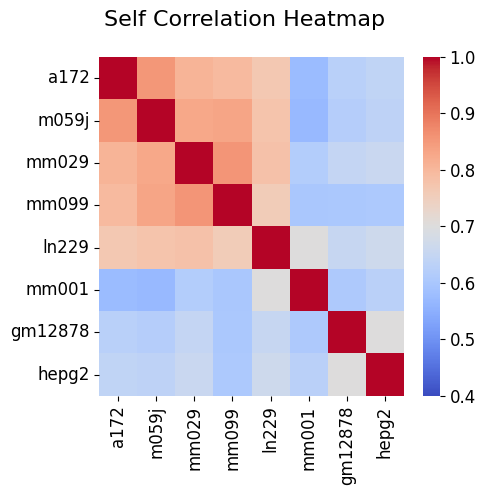

In [9]:
crested.pl.heatmap.correlations_self(
    adata[['a172', 'm059j', 'mm029', 'mm099', 'ln229',  'mm001', 'gm12878', 'hepg2'], :],
    title="Self Correlation Heatmap",
    x_label_rotation=90,
    width=5,
    height=5,
    vmax=1.0,
    vmin=0.4,
)

2025-03-30T04:49:03.540025+0200 INFO Plotting heatmap correlations for split: test, models: ['DeepCCL - Base', 'ChromBPNet - Base']


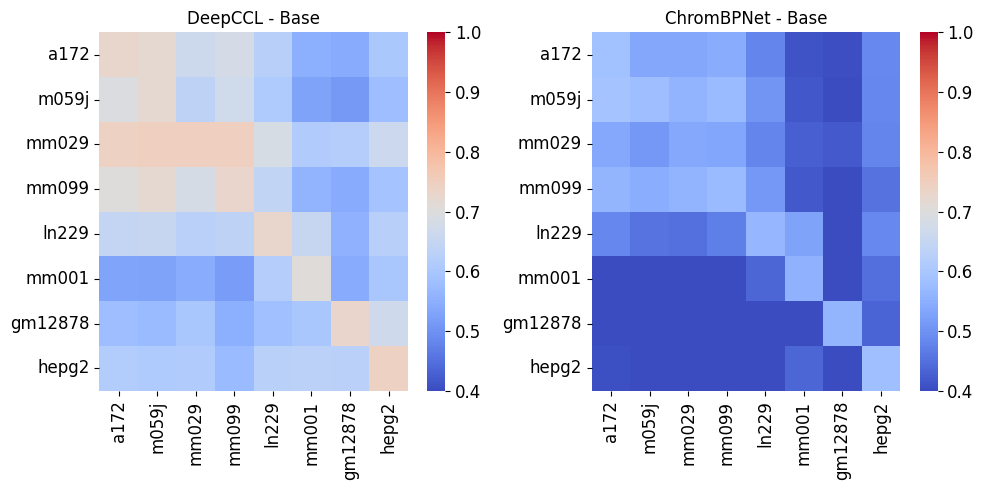

In [10]:
crested.pl.heatmap.correlations_predictions(
    adata[['a172', 'm059j', 'mm029', 'mm099', 'ln229',  'mm001', 'gm12878', 'hepg2'], :],
    split="test",
    x_label_rotation=90,
    width=10,
    height=5,
    vmax=1.0,
    vmin=0.4,
)

Save anndata with predictions

In [11]:
adata.write_h5ad(output_path.joinpath(Path("data/normalized_data_003_pred.h5ad")))

## Cell-type specific peaks (Figure 4b, S10b)

In [12]:
adata = anndata.read_h5ad(output_path.joinpath(Path("data/filtered_data_003_cvmedian.h5ad")))
datamodule = AnnDataModule(
    adata,
    chromsizes_file=genome_chrom_sizes,
    batch_size=512,
    max_stochastic_shift=0,
    always_reverse_complement=False,
)

DeepCCL

In [13]:
# Checkpoints: 10 (poissonlog, lion)
evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/DeepCCL.keras")),
    compile=True,
)

evaluator.predict(
    adata,
    model_name="DeepCCL"
)

406/406 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step
2025-03-30T04:51:13.365806+0200 INFO Adding predictions to anndata.layers[DeepCCL].


Ensemble ChromBPNet

In [14]:
evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/chrombpnet_ens.keras")),
    compile=True,
)
evaluator.predict(
    adata,
    model_name="ChromBPNet - Base"
)

406/406 ━━━━━━━━━━━━━━━━━━━━ 597s 1s/step
2025-03-30T05:01:20.525388+0200 INFO Adding predictions to anndata.layers[ChromBPNet - Base].


Ensemble ChromBPNet (Finetuned)

In [16]:
evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/chrombpnet_ens_ft.keras")),
    compile=False,
)
evaluator.predict(
    adata,
    model_name="ChromBPNet - FT"
)

406/406 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step
2025-03-30T05:18:09.603999+0200 INFO Adding predictions to anndata.layers[ChromBPNet - FT].


### Figure 4b

2025-03-30T05:46:54.430731+0200 INFO Plotting heatmap correlations for split: test, models: ['DeepCCL']


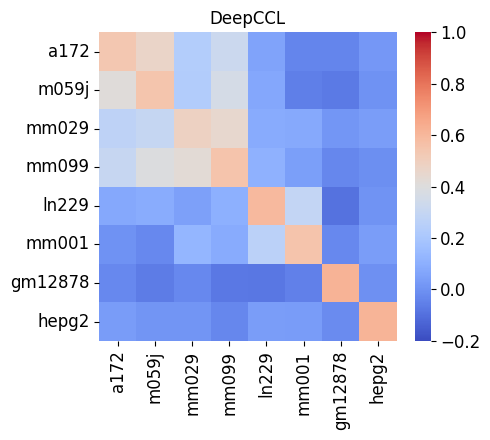

In [17]:
crested.pl.heatmap.correlations_predictions(
    adata[['a172', 'm059j', 'mm029', 'mm099', 'ln229',  'mm001', 'gm12878', 'hepg2'], :],
    split="test",
    model_names=['DeepCCL'],
    x_label_rotation=90,
    width=5,
    height=4.5,
    vmax=1.0,
    vmin=-0.2,
)

### Figure S10b

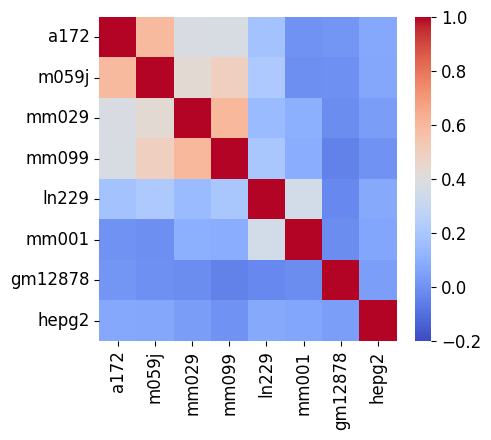

In [18]:
crested.pl.heatmap.correlations_self(
    adata[['a172', 'm059j', 'mm029', 'mm099', 'ln229',  'mm001', 'gm12878', 'hepg2'], :],
    x_label_rotation=90,
    width=5,
    height=4.5,
    vmax=1.0,
    vmin=-0.2,
)

2025-03-30T05:47:14.158478+0200 INFO Plotting heatmap correlations for split: test, models: ['ChromBPNet - Base', 'ChromBPNet - FT']


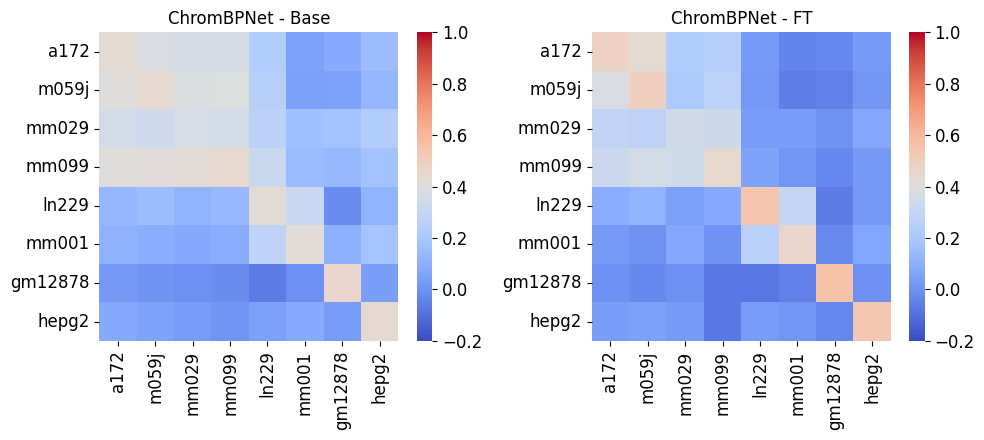

In [19]:
crested.pl.heatmap.correlations_predictions(
    adata[['a172', 'm059j', 'mm029', 'mm099', 'ln229',  'mm001', 'gm12878', 'hepg2'], :],
    split="test",
    model_names=["ChromBPNet - Base", "ChromBPNet - FT"],
    x_label_rotation=90,
    width=10,
    height=4.5,
    vmax=1.0,
    vmin=-0.2,
)

Save anndata with predictions

In [20]:
adata.write_h5ad(output_path.joinpath(Path("data/filtered_data_003_cvmedian_pred.h5ad")))

## Violin plots (Figure 4c)

Load full and cell-type results

In [21]:
preds = {}
class_corr_full = {}
adata = anndata.read_h5ad(output_path.joinpath(Path("data/normalized_data_003_pred.h5ad")))
x = np.log1p(adata.X[:, adata.var['split'] == 'test'])
preds['base_true'] = x.flatten()

for model_name in ['DeepCCL - Base', 'ChromBPNet - Base']:
    y = np.log1p(adata.layers[model_name][:, adata.var['split'] == 'test'])
    preds[f'{model_name}_bs'] = y.flatten()
    class_corr_mat = np.corrcoef(x, y, rowvar = True)
    class_corr_full[model_name] = np.diag(np.hsplit(np.vsplit(class_corr_mat, 2)[1], 2)[0])

class_corr_ct = {}
adata = anndata.read_h5ad(output_path.joinpath(Path("data/filtered_data_003_cvmedian_pred.h5ad")))
x = np.log1p(adata.X[:, adata.var['split'] == 'test'])
preds['ft_true'] = x.flatten()

for model_name in ['DeepCCL', 'ChromBPNet - Base']:
    y = np.log1p(adata.layers[model_name][:, adata.var['split'] == 'test'])
    preds[f'{model_name}_ft'] = y.flatten()
    class_corr_mat = np.corrcoef(x, y, rowvar = True)
    class_corr_ct[model_name] = np.diag(np.hsplit(np.vsplit(class_corr_mat, 2)[1], 2)[0])

Plotting

/tmp/ipykernel_489111/4059193874.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs['A'].set_xticklabels(axs['A'].get_xticklabels(), ha='center', rotation_mode='anchor', fontsize=10, family='sans-serif')
/tmp/ipykernel_489111/4059193874.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs['B'].set_xticklabels(axs['B'].get_xticklabels(), ha='center', rotation_mode='anchor', fontsize=10)


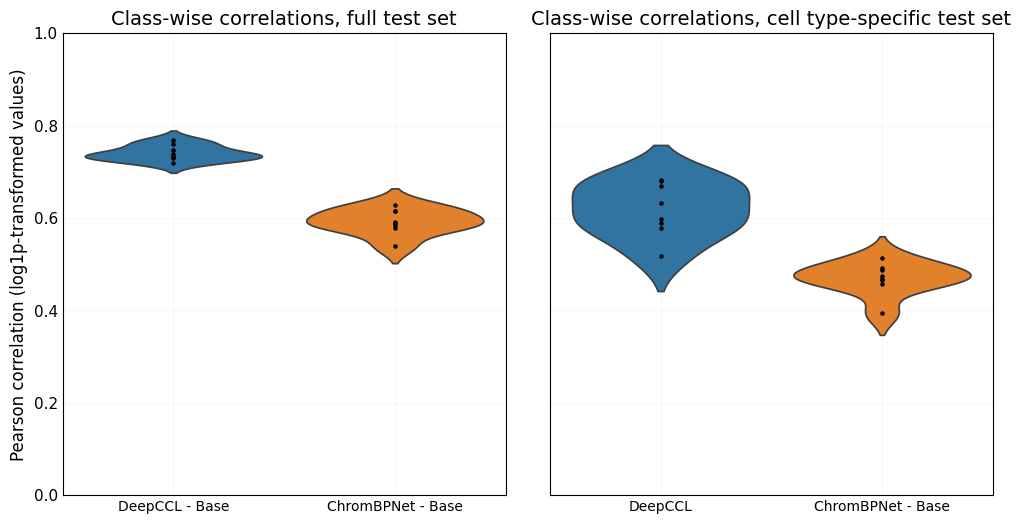

In [22]:
fig, axs = plt.subplot_mosaic("AB", sharex = False, sharey = True, figsize = (12, 6))
axs['A'].grid(visible=True, which='major', axis='y', color = '.85')
sns.violinplot(class_corr_full, inner = 'point', ax = axs['A'], zorder = 2.4,  inner_kws={'s': 20, 'marker': '.', 'edgecolor': '0', 'color': '0.01', 'alpha': 1})
axs['A'].tick_params(axis='x', labelrotation=0)
axs['A'].set_xticklabels(axs['A'].get_xticklabels(), ha='center', rotation_mode='anchor', fontsize=10, family='sans-serif')

axs["A"].tick_params(axis='y', labelsize=11)
plt.setp(axs["A"].get_yticklabels(), family='sans-serif')

axs['A'].set_ylabel("Pearson correlation (log1p-transformed values)", fontsize=12, family='sans-serif')
axs['A'].set_ylim((0, 1))
axs['A'].set_title("Class-wise correlations, full test set", fontsize=14, family='sans-serif')


axs['B'].grid(visible=True, which='major', axis='y', color = '.85')
sns.violinplot(class_corr_ct, inner = 'point', ax = axs['B'], zorder = 2.4, orient='v', inner_kws={'s': 20, 'marker': '.', 'edgecolor': '0', 'color': '0.01', 'alpha': 1})
axs['B'].tick_params(axis='x', labelrotation=0)
axs['B'].set_xticklabels(axs['B'].get_xticklabels(), ha='center', rotation_mode='anchor', fontsize=10)
axs['B'].set_ylabel("Pearson correlation (log1p-transformed values)")
axs['B'].set_ylim((0, 1))
axs['B'].set_title("Class-wise correlations, cell type-specific test set", fontsize=14, family='sans-serif')

plt.subplots_adjust(wspace=0.1)

axs["A"].grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.1)
axs["A"].set_facecolor('white')
axs["A"].tick_params(axis='both', which='both', length=0)

axs["B"].grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.1)
axs["B"].set_facecolor('white')
axs["B"].tick_params(axis='both', which='both', length=0)
fig.show()

# Interpret model predictions (Figure 4d & S10c/d)

In [24]:
labels = ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099']
classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']

adata = anndata.read_h5ad(output_path.joinpath(Path("data/filtered_data_003_cvmedian.h5ad")))
datamodule = AnnDataModule(
    adata,
    chromsizes_file=genome_chrom_sizes,
    batch_size=32,
    max_stochastic_shift=0,
    always_reverse_complement=False,
)

evaluator = crested.tl.Crested(data=datamodule)
evaluator.load_model(
    output_path.joinpath(Path("models/DeepCCL.keras")),
    compile=True,
)

Load DeepMEL2 and ChromBPNet models

In [25]:
# DeepMEL2
model_path, output_names = crested.get_model("DeepMEL2")
deepmel2_adata = anndata.AnnData(
    X=np.zeros((len(output_names), 1)),
    obs=pd.DataFrame(
        index=output_names
    ),
    var=pd.DataFrame(
        index=["chr2:20040502-20041072"]  # random region
    )
)
deepmel2_adata.obs = pd.DataFrame(index=output_names)
deepmel2_datamodule = crested.tl.data.AnnDataModule(
    deepmel2_adata,
    batch_size=32,
)
deepmel2 = crested.tl.Crested(data=deepmel2_datamodule)
deepmel2.load_model(model_path, compile=True)

## AXL enhancer (Figure 4d & S10d)

### DeepCCL (Figure 4d)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1743308557.991331  539373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


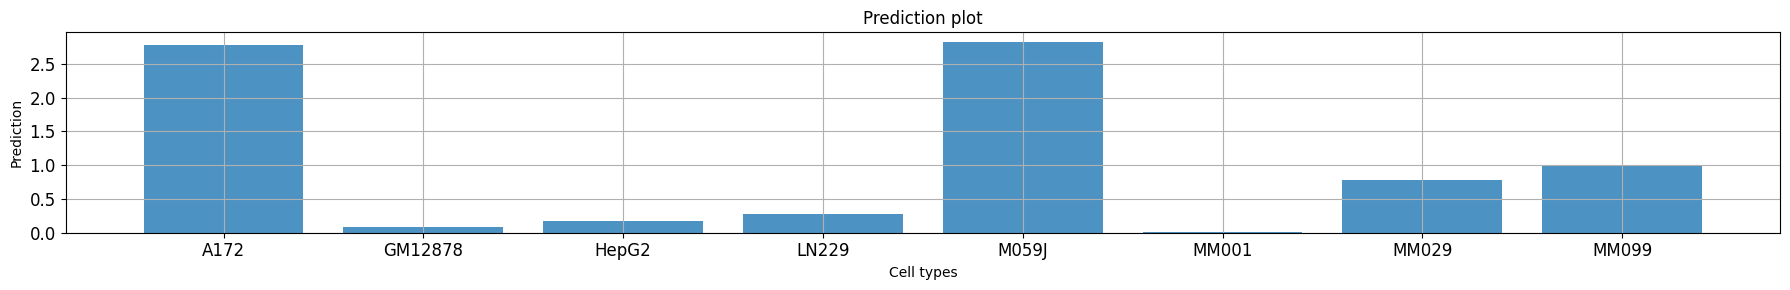

In [8]:
# AXL chr19:41223464-41223964 (hg38)
regions_of_interest = [
    'chr19:41222657-41224771'
]

prediction = evaluator.predict_regions(regions_of_interest)
crested.pl.bar.prediction(prediction, classes=labels)

A172

In [27]:
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=regions_of_interest,
    class_names=['a172'],
    method='expected_integrated_grad',
)

Region: 100%|██████████| 1/1 [01:34<00:00, 94.91s/it]


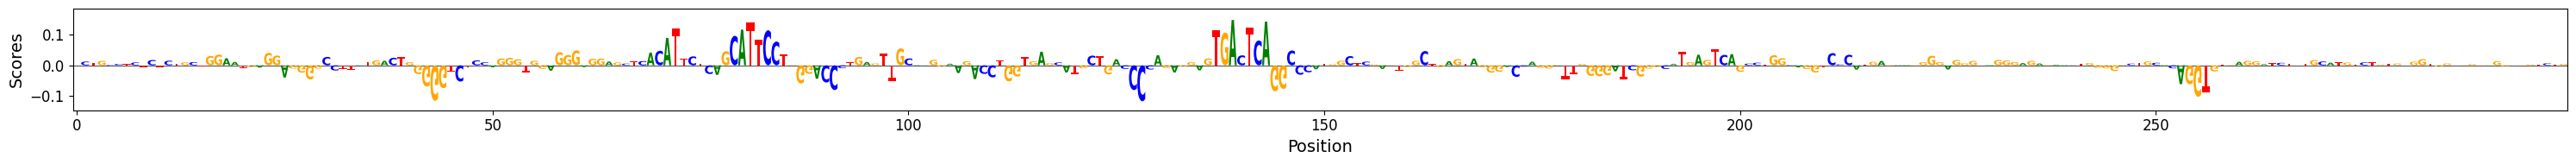

In [28]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[],
    class_labels=[],
    zoom_n_bases=300,
    # save_path="AXL_300_a172.pdf",
)

MM029

In [33]:
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=regions_of_interest,
    class_names=['mm029'],
    method='expected_integrated_grad',
)

Region: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


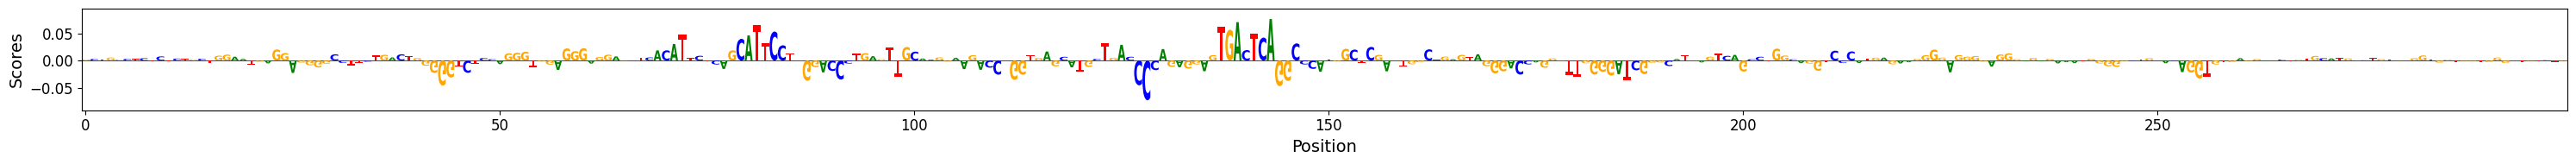

In [34]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[],
    class_labels=[],
    zoom_n_bases=300,
    # save_path="AXL_300_mm029.pdf",
)

### Figure S10d

ChromBPNet ensemble

In [ ]:
chrombpnet = keras.models.load_model(
    output_path.joinpath(Path("models/chrombpnet_ens.keras"))
)

In [12]:
regions_of_interest = [
    'chr19:41222657-41224771'
]

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    input=regions_of_interest,
    target_idx=0,
    model=chrombpnet,
    batch_size=8,
    method='expected_integrated_grad',
)

2025-03-30T06:46:01.143690+0200 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:16<00:00, 16.28s/it]


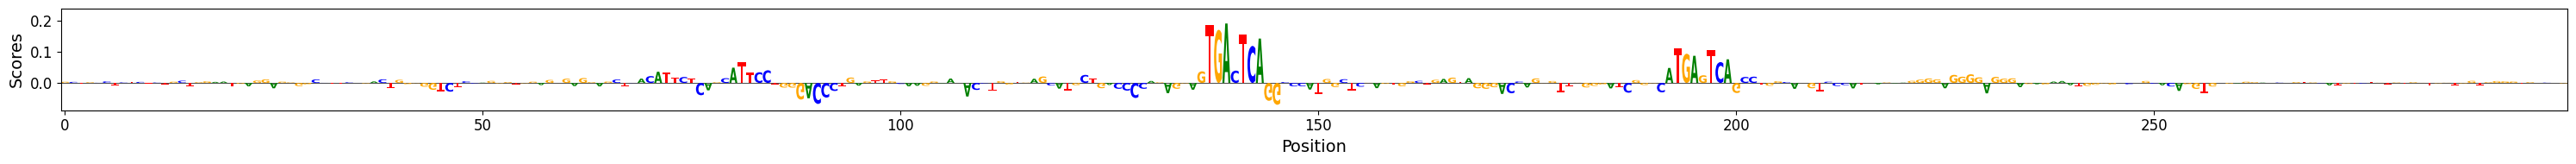

In [13]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[],
    class_labels=[],
    zoom_n_bases=300,
    # save_path="chrombpnet_AXL_300_a172.pdf",
)

MM029

In [15]:
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    input=regions_of_interest,
    target_idx=6,
    model=chrombpnet,
    batch_size=8,
    method='expected_integrated_grad',
)

2025-03-30T06:47:28.637024+0200 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:16<00:00, 16.04s/it]


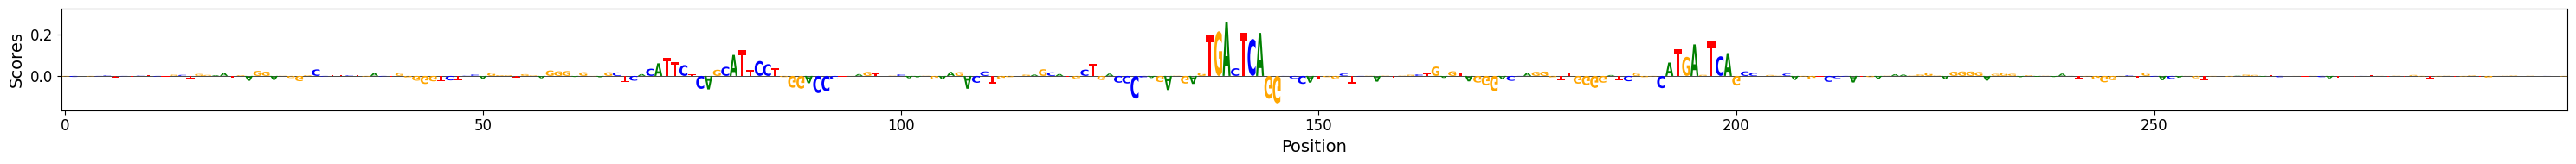

In [16]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[],
    class_labels=[],
    zoom_n_bases=300,
    # save_path="chrombpnet_AXL_300_mm029.pdf",
)

DeepMEL2

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


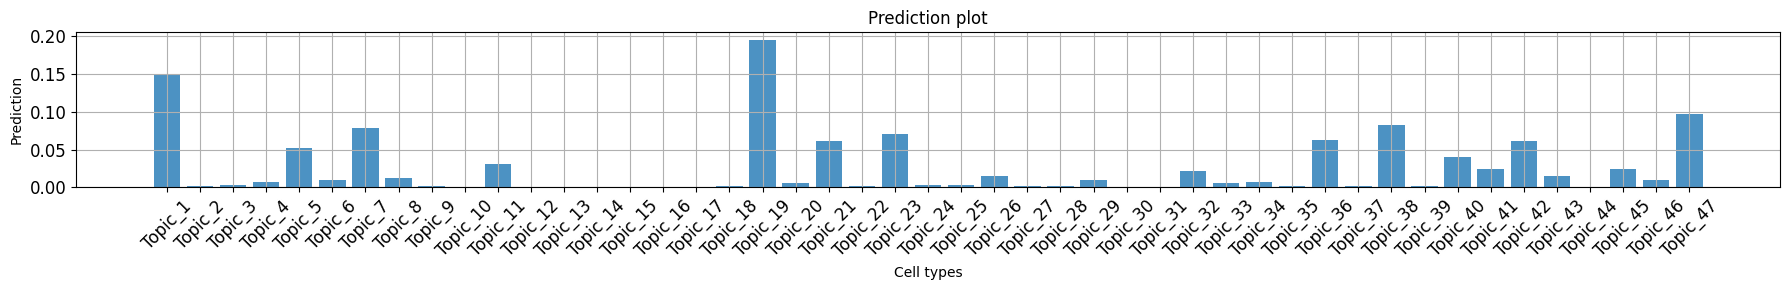

In [21]:
regions_of_interest = [
    'chr19:41223464-41223964'
]

prediction = deepmel2.predict_regions(regions_of_interest)
crested.pl.bar.prediction(prediction, classes=deepmel2_adata.obs_names, x_label_rotation=45)

In [22]:
scores, one_hot_encoded_sequences = deepmel2.calculate_contribution_scores_regions(
    region_idx=regions_of_interest,
    class_names=['Topic_19'],
    method='expected_integrated_grad',
)

Region: 100%|██████████| 1/1 [00:18<00:00, 18.97s/it]


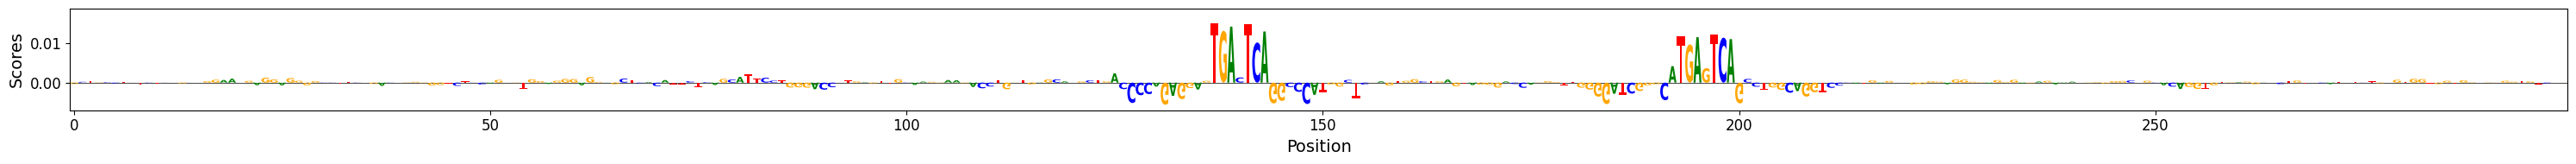

In [23]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[],
    class_labels=[],
    zoom_n_bases=300,
    # save_path="deepmel2_AXL_300_topic19.pdf",
)

## Kircher IRF4 enhancer (Figure S10c)

DeepCCL

In [38]:
# IRF4 enhancer
regions_of_interest = [
    "chr6:395311-397425"
]
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=regions_of_interest,
    class_names=['mm001'],
    method='mutagenesis',
)
genome_seq = crested.utils._utils.fetch_sequences('chr6:396142-396593', genome_fasta)

Region: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


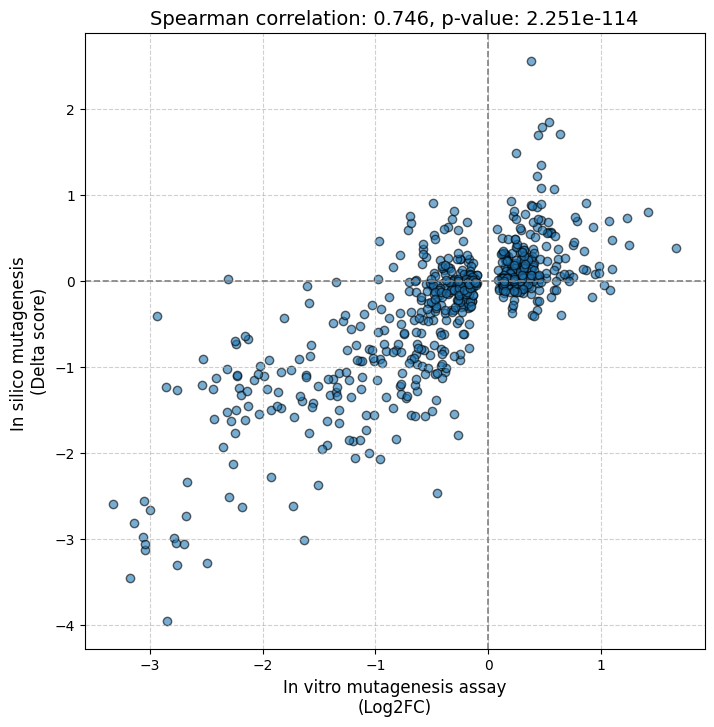

In [39]:
plot_kircher_correlation(
    scores,
    genome_seq,
    path=data_dir.joinpath('GRCh38_IRF4.tsv'),
    length=451,
    shift_model=831,
    shift_mpra=396143, 
    pval_threshold=1e-5,
    correlation='spearman',
    rasterized=True,
)

ChromBPNet

In [45]:
# IRF4 enhancer
regions_of_interest = [
    "chr6:395311-397425"
]
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    input=regions_of_interest,
    target_idx=5,
    model=chrombpnet,
    batch_size=8,
    method='mutagenesis',
)
genome_seq = crested.utils._utils.fetch_sequences('chr6:396142-396593', genome_fasta)

2025-03-30T06:56:47.651998+0200 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:16<00:00, 16.64s/it]


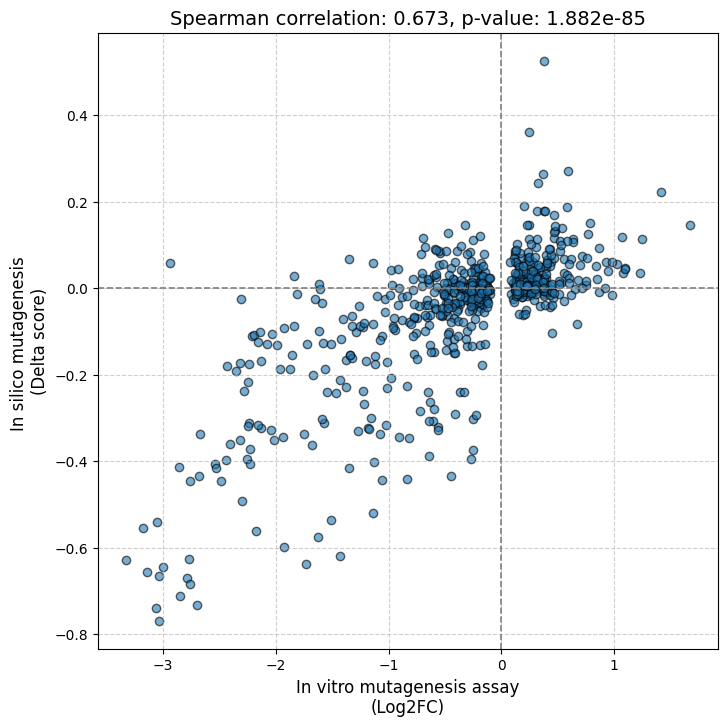

In [46]:
plot_kircher_correlation(
    scores,
    genome_seq,
    path=data_dir.joinpath('GRCh38_IRF4.tsv'),
    length=451,
    shift_model=831,
    shift_mpra=396143, 
    pval_threshold=1e-5,
    correlation='spearman',
    rasterized=True,
)

DeepMEL2

In [60]:
# IRF4 enhancer
regions_of_interest = [
    "chr6:396142-396642"
]
scores, one_hot_encoded_sequences = deepmel2.calculate_contribution_scores_regions(
    region_idx=regions_of_interest,
    class_names=['Topic_16'],
    method='mutagenesis',
)
genome_seq = crested.utils._utils.fetch_sequences('chr6:396142-396593', genome_fasta)

Region: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


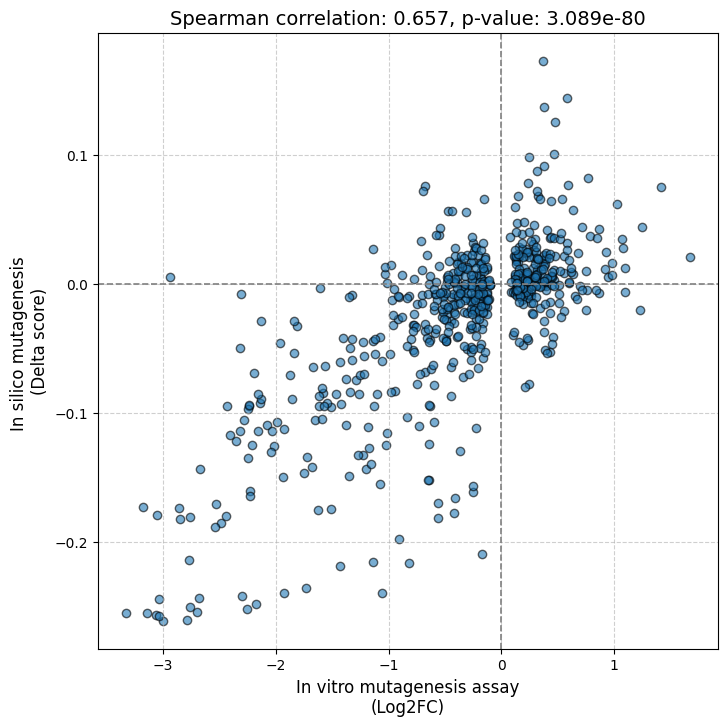

In [61]:
plot_kircher_correlation(
    scores,
    genome_seq,
    path=data_dir.joinpath('GRCh38_IRF4.tsv'),
    length=451,
    shift_model=0,
    shift_mpra=396143, 
    pval_threshold=1e-5,
    correlation='spearman',
    rasterized=True,
)